## <center> 1. Alarms Classification (Noisy and Failure Alarms)

Importing required libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn import preprocessing
from category_encoders import one_hot
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import roc_curve, auc

# plt.style.reload_library()
# plt.style.use(['science','notebook'])


Controlling randomness of simulation / For reproducibility of results!

In [2]:
import os
import random
import time 

SEED = 1

os.environ['PYTHONHASHSEED'] =str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

random.seed(SEED)
np.random.seed(SEED)

In [3]:
service = 1    #select service/subnetwork 1 or 2

cols_to_drop = ['Failure_Alarm', 'Magnitude', 'Service', 'Attenuation','Position']    #redundant features
cols_to_scale = ['AFFECTEDOBJECTNAME','NENAME', 'ALARMNAME', 'PROBABLECAUSE', 'ADDITIONALTEXT']   #categorical features

def get_data():
    
    df = pd.read_excel('combined_data_for_both_services.xlsx')    #Dataset is now loaded in a Pandas Dataframe
    
#     print("Number of Samples of each service ")
#     print(df.Service.value_counts())
    
    df_service_x = df[df.Service == service].copy()   #considered service
    
    print("\nShape of dataset before removing duplicates : ", df_service_x.shape)
    df_service_x.drop_duplicates(inplace = True)
    print("\nShape of dataset after removing duplicates : ", df_service_x.shape)
    
    return df_service_x.copy()

#### RareLabelEncoder

The RareLabelEncoder() groups labels that show a small number of observations in the dataset into a new category called 'Rare'. This helps to avoid overfitting.

The argument ' tol ' indicates the percentage of observations that the label needs to have in order not to be re-grouped into the "Rare" label.
The argument n_categories indicates the minimum number of distinct categories that a variable needs to have for any of the labels to be re-grouped into 'Rare'.

n_categories (int, default=10) – the minimum number of categories a variable should have for the encoder to find frequent labels.

#### Note:
If the number of labels is smaller than n_categories, then the encoder will not group the labels for that variable.

In [4]:
def get_stats_of_dataset(data):
    print("Number of labels in each feature : \n\n")
    for col in data.columns:
        print(col, ': ', len(data[col].unique()), ' labels')
    
    for col in data.columns[0:3]:
        print('\nFeature : ', col)
        print("\n")
        print(df_service[col].value_counts().sort_values(ascending=False).head(20))

In [5]:
rare_encoder = RareLabelEncoder(tol=0.01, 
                                n_categories = 3,
                                variables= cols_to_scale)

def get_rare_Encoded_Data(df_service_x):
    
    X = df_service_x.drop(cols_to_drop, axis= 'columns')
    y = df_service_x.Failure_Alarm
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= SEED, shuffle = True, stratify = y)

    print("Size of training data: ", X_train.shape)
    print("Size of test data: ", X_test.shape)
    
    #more realistic scenario; seperate transformation on test and train dataset
    rare_encoder.fit(X_train) 
    
    train_t = rare_encoder.transform(X_train)   #transformed training set
    test_t = rare_encoder.transform(X_test)
    
    print("Size of Rare encoded training data: ", train_t.shape)
    print("Size of Rare encoded test data: ", test_t.shape)
    
    return train_t, test_t, y_train, y_test


In [6]:
df_service = get_data()

Number of Samples of each service 
1    2001
2    1398
Name: Service, dtype: int64

Shape of dataset before removing duplicates :  (2001, 11)

Shape of dataset after removing duplicates :  (2001, 11)


In [7]:
# get_stats_of_dataset(df_service)

In [8]:
train_t, test_t, y_train, y_test = get_rare_Encoded_Data(df_service)

Size of training data:  (1400, 6)
Size of test data:  (601, 6)
Size of Rare encoded training data:  (1400, 6)
Size of Rare encoded test data:  (601, 6)


In [9]:
# get_stats_of_dataset(train_t)

Normalization across instances should be done after splitting the data between training and test set, using only the data from the training set.

This is because the test set plays the role of fresh unseen data, so it's not supposed to be accessible at the training stage. Using any information coming from the test set before or during training is a potential bias in the evaluation of the performance.

When normalizing the test set, one should apply the normalization parameters previously obtained from the training set as-is. Do not recalculate them on the test set, because they would be inconsistent with the model and this would produce wrong predictions.


Source: https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

In [10]:
rbst_scaler = RobustScaler()   #For normalizing FDN as FDN has wide range of numbers (Robust scaler is robust to noise)

# Initiliazing the Category Encoders OHE object
ce_ohe = one_hot.OneHotEncoder(use_cat_names = True)

#initializing only on training data
ce_ohe_fitted = ce_ohe.fit(train_t[cols_to_scale])   
rbst_scaler_fitted = rbst_scaler.fit(np.array(train_t['FDN']).reshape(-1, 1))

def data_transformer (temp_df):
    
    ce_dummies = ce_ohe_fitted.transform(temp_df[cols_to_scale])
    
    temp_df['FDN'] = rbst_scaler_fitted.transform(np.array(temp_df['FDN']).reshape(-1, 1))
        
    temp_df = temp_df.drop(cols_to_scale , axis = 'columns')
    
    resultant_df = pd.concat([ce_dummies, temp_df], axis=1, join='inner') 
    
    return resultant_df.copy()   #returns normalized dataset

In [11]:
#seperate normalization of test and train data: realistic scenario

X_train_encoded = data_transformer(train_t)
X_test_encoded = data_transformer(test_t)

In [12]:
X_train_encoded.shape

(1400, 94)

In [13]:
X_test_encoded.shape

(601, 94)

In [14]:
y_train.value_counts()

0    779
1    621
Name: Failure_Alarm, dtype: int64

In [15]:
y_test.value_counts()

0    335
1    266
Name: Failure_Alarm, dtype: int64

Test and train datasets can have different dimensions (if data normalizer is not fit on only training data), which is not desired for training and testing of ML model. The following statement balances the dimensions of both datasets by discarding max(test_data.size[1], train_data.size[1]) - min(test_data.size[1], train_data.size[1]) number of features.


In [16]:
#Though not required here but it is not harming either.
final_train, final_test = X_train_encoded.align(X_test_encoded, join='inner', axis=1)  # inner join

There can be unsupported characters in the feature names obtained from raw data. Some sklearn models do not process such features, hence removing such characters from feature names.

In [17]:
import re
final_train = final_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
final_test = final_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [18]:
final_train.shape , final_test.shape

((1400, 94), (601, 94))

In [19]:
y_train.shape , y_test.shape

((1400,), (601,))

Up till this point with 1% threshold for rare label encoding, we ended with 109 dimensions of training and test data sets which are quite high considering the number of samples in training dataset (i.e., 955). Hence, using Principal Component Analysis (PCA) to reduce the dimensions further.

#### PCA

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting information from a high-dimensional space by projecting  it into a lower-dimensional sub-space. 

It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

In [20]:
from sklearn.decomposition import PCA    
pca = PCA(0.98)                #Figuring out dimensions that contain 98% of information of actual data 
pca_fitted = pca.fit(final_train)
final_train_pca = pca_fitted.transform(final_train)
final_train_pca.shape

(1400, 57)

57 dimensions represent 98% of information in our dataset. Applying same transformation of test dataset as well.

In [21]:
final_test_pca = pca_fitted.transform(final_test)
final_test_pca.shape

(601, 57)

In [22]:
final_test , final_train = final_test_pca , final_train_pca 
final_test.shape , final_train.shape

((601, 57), (1400, 57))

## Machine Learning models

#### Hyper-parameter Tuning

Using RandomizedSearchCV to reduce number of iterations and with random combination of parameters. This is useful when we have too many parameters to try and our training time is longer. It helps to reduce the cost of computation.

#### Gamma and C parameters in SVM:

Intuitively, the gamma parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.

Source: https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html


Interesting explanation: https://www.youtube.com/watch?v=fqhHBCfNy6s

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm

rs = RandomizedSearchCV(svm.SVC(gamma='auto'), {
        'C': [1,5,10,15, 20, 25, 30],
        'kernel': ['rbf','linear']
    }, 
                        
    cv=5,          #5 folds cross-validation
    n_iter= 12,    #number of combinations to check
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs.fit(final_train, y_train)

pd.DataFrame(rs.cv_results_)[['param_C','param_kernel','mean_test_score']]

Fitting 5 folds for each of 12 candidates, totalling 60 fits


,param_C,param_kernel,mean_test_score
0,5,linear,0.992143
1,15,linear,0.992143
2,15,rbf,0.992143
3,5,rbf,0.983571
4,25,rbf,0.992143
5,10,rbf,0.990000
6,1,linear,0.992143
7,30,rbf,0.992143
8,1,rbf,0.959286
9,30,linear,0.992143


In [24]:
print('Best Score : ' , rs.best_score_)
print('Best Parameters : ' ,rs.best_params_)

Best Score :  0.9921428571428571
Best Parameters :  {'kernel': 'linear', 'C': 5}


Now define the model with the best performing hyperparameters:
Train it and test on the unseen dataset.

In [25]:
model_svm = svm.SVC(kernel= rs.best_params_.get('kernel'),C= rs.best_params_.get('C'),gamma='auto', random_state = SEED)

#computing training time
start_time_svm = time.time()
model_svm.fit(final_train, y_train)
elapsed_time_svm = time.time() - start_time_svm
elapsed_time_svm

0.016954660415649414

In [26]:
model_svm.score(final_test, y_test)

0.9833610648918469

In [27]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sn

def plot_results(model, X_test, y_test):
    y_predicted = model.predict(X_test)
    cm = confusion_matrix(y_test, y_predicted)
    plt.figure(figsize=(10,7))
    sn.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    
    print('\n\nClassification Report : \n')
    print(classification_report(y_test, y_predicted))
    
    report = classification_report(y_test, y_predicted, output_dict=True)
    
    #ROC curve 
    fpr, tpr, _ = roc_curve(y_test, y_predicted)
    auc_t = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, marker='.', label='(AUC = %0.4f)' % auc_t)
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    
    return fpr, tpr, auc_t, report['macro avg']['f1-score']



Classification Report : 

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       335
           1       0.96      1.00      0.98       266

    accuracy                           0.98       601
   macro avg       0.98      0.99      0.98       601
weighted avg       0.98      0.98      0.98       601



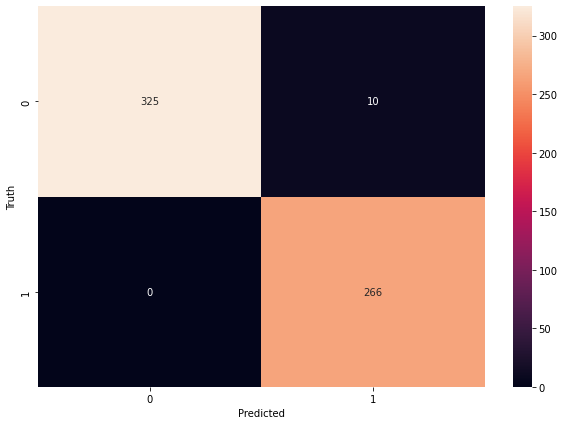

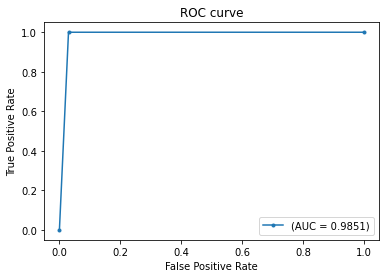

In [28]:
fpr_svm , tpr_svm, auc_svm, f1_score_svm = plot_results(model_svm, final_test, y_test)

#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

rs_2 = RandomizedSearchCV(RandomForestClassifier(), {
        'n_estimators': [1,5,10,15, 20, 25, 30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500,1000], 
    }, 
    cv=5, 
    n_iter= 20,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_2.fit(final_train, y_train)

pd.DataFrame(rs_2.cv_results_)[['param_n_estimators','mean_test_score']]

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_n_estimators,mean_test_score
0,100,0.999286
1,150,0.998571
2,15,0.995714
3,110,0.998571
4,300,0.999286
5,140,0.999286
6,70,1.000000
7,20,0.997143
8,10,0.994286
9,200,0.998571


In [30]:
print('Best Score : ' , rs_2.best_score_)
print('Best Parameters : ' ,rs_2.best_params_)

Best Score :  1.0
Best Parameters :  {'n_estimators': 70}


In [31]:
model_rf = RandomForestClassifier(n_estimators=rs_2.best_params_.get('n_estimators'), random_state = SEED)

start_time_rf = time.time()
model_rf.fit(final_train, y_train)
elapsed_time_rf = time.time() - start_time_rf 

elapsed_time_rf

0.24004745483398438

In [32]:
model_rf.score(final_test, y_test)

0.9983361064891847



Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       1.00      1.00      1.00       266

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



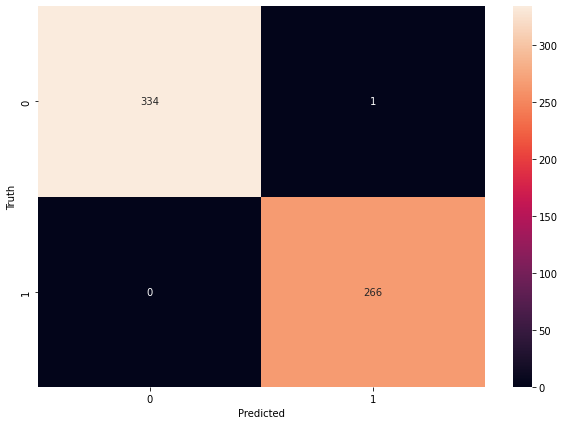

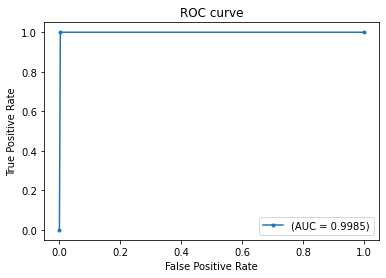

In [33]:
fpr_rf , tpr_rf, auc_rf, f1_score_rf = plot_results(model_rf, final_test, y_test)

#### KNN (K Neighrest Neighbour Classifier)

When k=1 you estimate your probability based on a single sample: your closest neighbor. This is very sensitive to all sort of distortions like noise, outliers, mislabelling of data, and so on. By using a higher value for k, you tend to be more robust against those distortions.

In [34]:
from sklearn.neighbors import KNeighborsClassifier

rs_3 = RandomizedSearchCV(KNeighborsClassifier(), {
        'n_neighbors': [10,15, 20, 25, 30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500],
    }, 
                          
    cv=5, 
    n_iter= 20,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_3.fit(final_train, y_train)

pd.DataFrame(rs_3.cv_results_)[['param_n_neighbors','mean_test_score']]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


,param_n_neighbors,mean_test_score
0,140,0.884286
1,90,0.892143
2,25,0.890000
3,300,0.897857
4,200,0.865714
5,130,0.885714
6,150,0.865714
7,30,0.905714
8,20,0.912143
9,50,0.886429


In [35]:
print('Best Score : ' , rs_3.best_score_)
print('Best Parameters : ' ,rs_3.best_params_)

Best Score :  0.9392857142857143
Best Parameters :  {'n_neighbors': 10}


In [36]:
model_knn = KNeighborsClassifier(n_neighbors=rs_3.best_params_.get('n_neighbors'))

start_time_knn = time.time()
model_knn.fit(final_train, y_train)
elapsed_time_knn = time.time() - start_time_knn 

elapsed_time_knn 

0.000997304916381836

In [37]:
model_knn.score(final_test, y_test)

0.9267886855241264



Classification Report : 

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       335
           1       0.91      0.93      0.92       266

    accuracy                           0.93       601
   macro avg       0.93      0.93      0.93       601
weighted avg       0.93      0.93      0.93       601



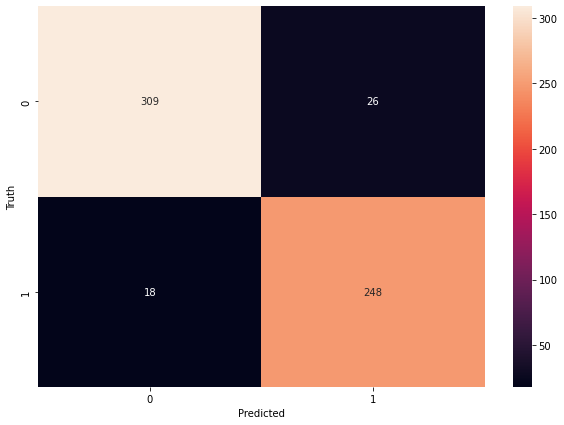

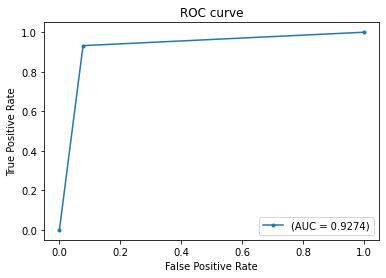

In [38]:
fpr_knn , tpr_knn, auc_knn, f1_score_knn = plot_results(model_knn, final_test, y_test)

#### Gradient Boosting Classifier

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
rs_4 = RandomizedSearchCV(GradientBoostingClassifier(), {
        'n_estimators': [1,5,10,15, 20, 25, 30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500,1000],
        'learning_rate' : [0.05, 0.075, 0.025, 0.001, 0.1, 0.25, 0.5, 0.75]
    }, 
                          
    cv=5, 
    n_iter= 30,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_4.fit(final_train, y_train)

pd.DataFrame(rs_4.cv_results_)[['param_n_estimators','param_learning_rate','mean_test_score']]

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,param_n_estimators,param_learning_rate,mean_test_score
0,300,0.075,0.998571
1,400,0.025,0.998571
2,140,0.5,0.998571
3,80,0.075,0.998571
4,110,0.75,0.998571
5,80,0.05,0.994286
6,10,0.25,0.986429
7,60,0.001,0.556429
8,110,0.1,0.998571
9,90,0.75,0.998571


In [41]:
print('Best Score : ' , rs_4.best_score_)
print('Best Parameters : ' ,rs_4.best_params_)

Best Score :  0.9985714285714286
Best Parameters :  {'n_estimators': 300, 'learning_rate': 0.075}


In [42]:
model_gbc = GradientBoostingClassifier(n_estimators = rs_4.best_params_.get('n_estimators'), learning_rate = rs_4.best_params_.get('learning_rate'), random_state = SEED)

start_time_gbc = time.time()
model_gbc.fit(final_train, y_train)
elapsed_time_gbc = time.time() - start_time_gbc 
elapsed_time_gbc


3.305880546569824

In [43]:
model_gbc.score(final_test, y_test)

0.9983361064891847



Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       1.00      1.00      1.00       266

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



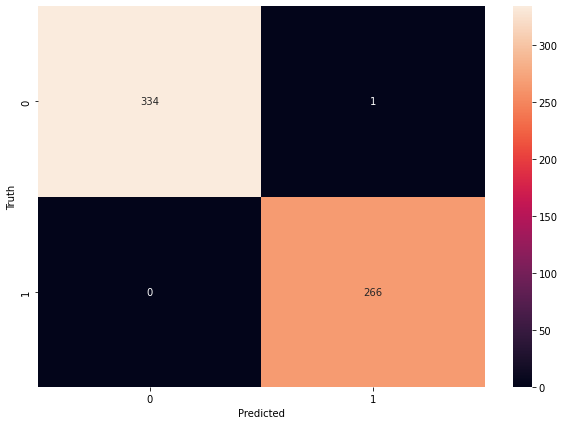

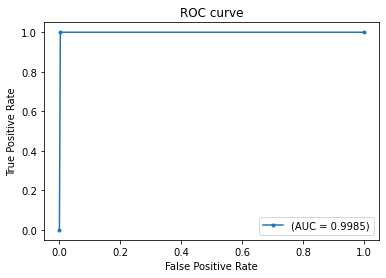

In [44]:
fpr_gb , tpr_gb, auc_gb, f1_score_gbc = plot_results(model_gbc, final_test, y_test)

#### XGBoost Classifier

In [45]:
from xgboost import XGBClassifier

In [46]:
rs_5 = RandomizedSearchCV(XGBClassifier(objective = 'binary:logistic'), {
        'n_estimators': [1,5,10,15, 20, 25, 30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500,1000],
        'learning_rate' : [0.05, 0.075, 0.025, 0.001, 0.1, 0.25, 0.5, 0.75]
    }, 
    cv=5, 
    n_iter= 30,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_5.fit(final_train, y_train)

pd.DataFrame(rs_5.cv_results_)[['param_n_estimators','param_learning_rate','mean_test_score']]


Fitting 5 folds for each of 30 candidates, totalling 150 fits


,param_n_estimators,param_learning_rate,mean_test_score
0,300,0.075,0.999286
1,400,0.025,0.999286
2,140,0.5,0.999286
3,80,0.075,0.998571
4,110,0.75,0.999286
5,80,0.05,0.996429
6,10,0.25,0.995714
7,60,0.001,0.969286
8,110,0.1,0.999286
9,90,0.75,0.999286


In [47]:
print('Best Score : ' , rs_5.best_score_)
print('Best Parameters : ' ,rs_5.best_params_)

Best Score :  0.9992857142857143
Best Parameters :  {'n_estimators': 300, 'learning_rate': 0.075}


In [48]:
model_xgbc = XGBClassifier(n_estimators = rs_5.best_params_.get('n_estimators'), learning_rate = rs_5.best_params_.get('learning_rate'), objective = 'binary:logistic', random_state = SEED)

start_time_xgbc = time.time()
model_xgbc.fit(final_train, y_train)
elapsed_time_xgbc = time.time() - start_time_xgbc 
elapsed_time_xgbc

0.3331422805786133

In [49]:
model_xgbc.score(final_test, y_test)

0.9983361064891847



Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       1.00      1.00      1.00       266

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



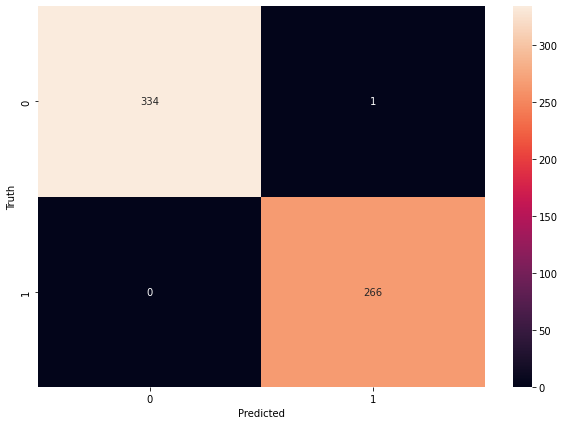

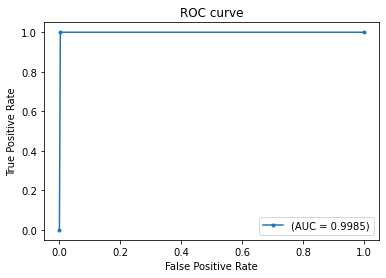

In [50]:
fpr_xgb , tpr_xgb, auc_xgb, f1_score_xgbc = plot_results(model_xgbc, final_test, y_test)

In [51]:
from lightgbm import LGBMClassifier

In [52]:
rs_6 = RandomizedSearchCV(LGBMClassifier(application = 'binary'), {
        'n_estimators': [1,5,10,15, 20, 25, 30,40,50,60,70,80,90,100,110,120,130,140,150,200,300,400,500,1000],
        'learning_rate' : [0.05, 0.075, 0.025, 0.001, 0.1, 0.25, 0.5, 0.75]
    }, 
    cv=5, 
    n_iter= 30,
    n_jobs = -1,   #use all processors in parallel
    random_state = SEED,
    verbose = 100  # For displaying information
)

rs_6.fit(final_train, y_train)

pd.DataFrame(rs_6.cv_results_)[['param_n_estimators','param_learning_rate','mean_test_score']]


Fitting 5 folds for each of 30 candidates, totalling 150 fits


,param_n_estimators,param_learning_rate,mean_test_score
0,300,0.075,1.000000
1,400,0.025,1.000000
2,140,0.5,0.999286
3,80,0.075,0.999286
4,110,0.75,0.998571
5,80,0.05,0.995714
6,10,0.25,0.993571
7,60,0.001,0.556429
8,110,0.1,0.999286
9,90,0.75,0.998571


In [53]:
print('Best Score : ' , rs_6.best_score_)
print('Best Parameters : ' ,rs_6.best_params_)

Best Score :  1.0
Best Parameters :  {'n_estimators': 300, 'learning_rate': 0.075}


In [54]:
model_lgbm = LGBMClassifier(n_estimators=rs_6.best_params_.get('n_estimators'),
                      random_state=SEED, application = 'binary',learning_rate = rs_6.best_params_.get('learning_rate'))

In [55]:
start_time_lgbm = time.time()
model_lgbm.fit(final_train, y_train)
elapsed_time_lgbm = time.time() - start_time_lgbm
elapsed_time_lgbm

0.16189908981323242

In [56]:
model_lgbm.score(final_test, y_test)

0.9983361064891847



Classification Report : 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       335
           1       1.00      1.00      1.00       266

    accuracy                           1.00       601
   macro avg       1.00      1.00      1.00       601
weighted avg       1.00      1.00      1.00       601



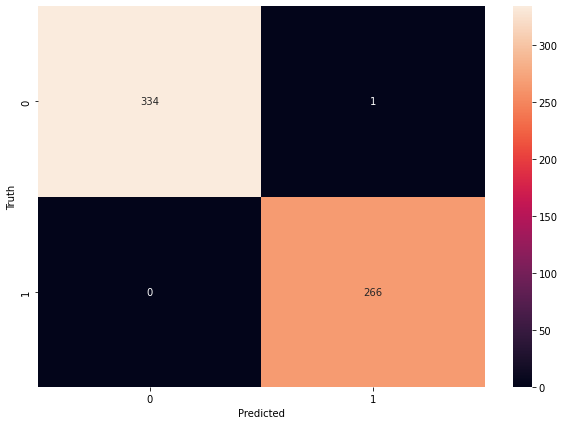

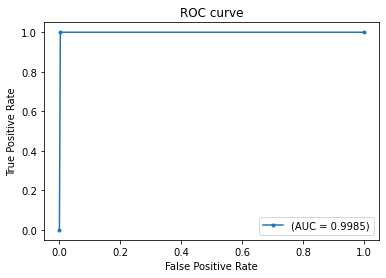

In [57]:
fpr_lgb , tpr_lgb, auc_lgb , f1_score_lgbm = plot_results(model_lgbm, final_test, y_test)

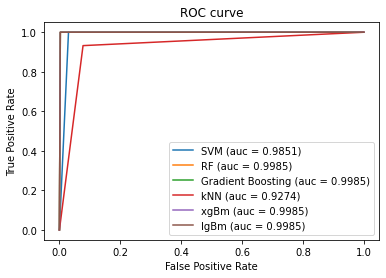

In [58]:
plt.figure()

plt.plot(fpr_svm, tpr_svm,  label='SVM (auc = %0.4f)' % auc_svm)
plt.plot(fpr_rf, tpr_rf,  label='RF (auc = %0.4f)' % auc_rf)
plt.plot(fpr_gb, tpr_gb,  label='Gradient Boosting (auc = %0.4f)' % auc_gb)
plt.plot(fpr_knn, tpr_knn, label='kNN (auc = %0.4f)' % auc_knn)
plt.plot(fpr_xgb, tpr_xgb,  label='xgBm (auc = %0.4f)' % auc_xgb)
plt.plot(fpr_lgb, tpr_lgb, label='lgBm (auc = %0.4f)' % auc_lgb)

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [59]:
training_times = {'SVM' : elapsed_time_svm,
                 'kNN': elapsed_time_knn,
                 'RF' : elapsed_time_rf,
                 'gbm': elapsed_time_gbc,
                 'xgbm': elapsed_time_xgbc,
                 'lgbm' : elapsed_time_lgbm}

models = list(training_times.keys())
t_times = list(training_times.values())

In [60]:
accuracies = {'SVM' : model_svm.score(final_test, y_test),
                 'kNN': model_knn.score(final_test, y_test),
                 'RF' : model_rf.score(final_test, y_test),
                 'gbm': model_gbc.score(final_test, y_test),
                 'xgbm': model_xgbc.score(final_test, y_test),
                 'lgbm' : model_lgbm.score(final_test, y_test)}

models = list(accuracies.keys())
acc = list(accuracies.values())

In [61]:
f1_scores = {'SVM' : f1_score_svm,
                 'kNN': f1_score_knn,
                 'RF' : f1_score_rf,
                 'gbm': f1_score_gbc,
                 'xgbm': f1_score_xgbc,
                 'lgbm' : f1_score_lgbm}

models = list(f1_scores.keys())
scores = list(f1_scores.values())

In [62]:
# # saving F1 scores, accuracy and training time dictionaries in CSV files

# df_training_time = pd.DataFrame.from_dict([training_times]) 
# df_training_time.to_csv (r'Training_time_seed_{}.csv'.format(SEED), header=True, index=[SEED])

# df_accuracy = pd.DataFrame.from_dict([accuracies]) 
# df_accuracy.to_csv (r'Accuracy_seed_{}.csv'.format(SEED),  header=True, index=[SEED])

# df_f1_score = pd.DataFrame.from_dict([f1_scores]) 
# df_f1_score.to_csv (r'f1_score_seed_{}.csv'.format(SEED),  header=True, index=[SEED])

#### Plot for 20 seeds

#### Service 1

In [63]:
df_accuracies_s1 = pd.read_csv('S1_FD_Accuracy.csv').mean(axis=0)
df_F1_scores_s1 = pd.read_csv('S1_FD_F1.csv').mean(axis=0)
df_training_times_s1 = pd.read_csv('S1_FD_TT.csv').mean(axis=0)

#### Service 2


In [64]:
df_accuracies_s2 = pd.read_csv('S2_FD_Accuracy.csv').mean(axis=0)
df_F1_scores_s2 = pd.read_csv('S2_FD_F1.csv').mean(axis=0)
df_training_times_s2 = pd.read_csv('S2_FD_TT.csv').mean(axis=0)

#### For Grouped Bar Plots

In [65]:
models_ml = df_F1_scores_s1.keys()   #extracting model names

f1_Scores_service_1 = df_F1_scores_s1.values  
f1_Scores_service_2 = df_F1_scores_s2.values

training_times_service_1 = df_training_times_s1.values
training_times_service_2 = df_training_times_s2.values

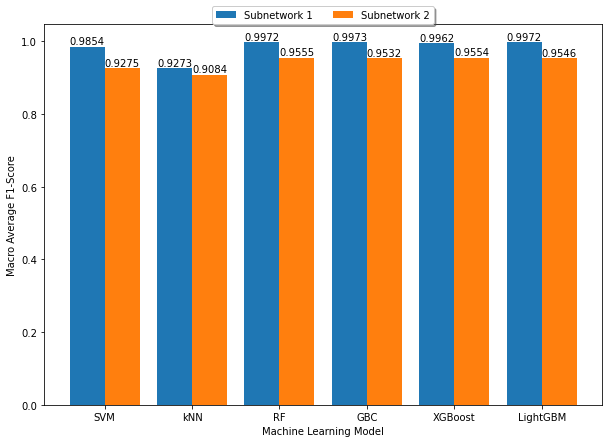

In [66]:
fig, ax = plt.subplots(figsize=(10,7))

# Multi bar Chart
x_axis = np.arange(len(models_ml))
p1 = ax.bar(x_axis -0.2, f1_Scores_service_1, width=0.4, label = 'Subnetwork 1')
p2 = plt.bar(x_axis +0.2, f1_Scores_service_2, width=0.4, label = 'Subnetwork 2')

for c in ax.containers: ax.bar_label(c, fmt='%.4f')    #for limiting bar labels up to four decimal places
    
plt.xticks(x_axis, models_ml)

# Add legend
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.06), ncol=3, fancybox=True, shadow=True)

# Display
plt.ylabel('Macro Average F1-Score')
plt.xlabel('Machine Learning Model')
plt.show()

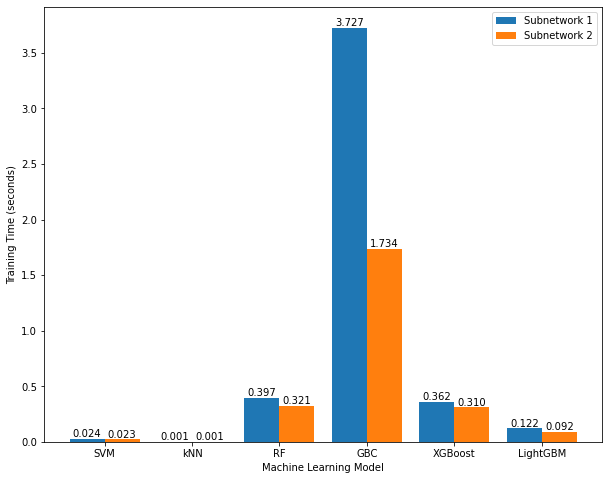

In [67]:
fig, ax = plt.subplots(figsize=(10,8))

# Multi bar Chart
x_axis = np.arange(len(models_ml))
p1 = ax.bar(x_axis -0.2, training_times_service_1, width=0.4, label = 'Subnetwork 1')
p2 = plt.bar(x_axis +0.2, training_times_service_2, width=0.4, label = 'Subnetwork 2')

for c in ax.containers: ax.bar_label(c, fmt='%.3f')

plt.xticks(x_axis, models_ml)

# Add legend
plt.legend()

# Display
plt.ylabel('Training Time (seconds)')
plt.xlabel('Machine Learning Model')
plt.show()